In [1]:
#Bayesian Optimization using Gaussian Processes for Hyperparameter Tuning with noisy experimental data.

import numpy as np
import torch
from pyDOE3 import lhs

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.optim import optimize_acqf

from gpytorch import kernels, means, likelihoods
from gpytorch.priors import LogNormalPrior
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
from matplotlib import cm

from gpytorch.constraints import Interval
from gpytorch.priors import SmoothedBoxPrior

from scipy.interpolate import griddata

/Users/s/PhD/gitrepo/bayesmediaopt/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
# ===========================

seed= 59 # keeps inputs generated from lhs consistent across runs (also feeds into numpy)
# might want to set tensor random seed

# This is one of the most important variables for applied purporses, as real world data is messy
noise_level = 25 # this var is used to denote the standard deviation of the noise in the data (therefore it is relative to the objective function mean.)
# For example, a noise_level = 1 = std means 68% of noise lies within 1 unit of the mean value of the objective function.

# noise boudarys for the likelihood (Gaussian) model (Ensures noise priors are realistic) these are standard deviations. The model success is heavily dependent on these being tuned.
lower_noise_bound = .1 
upper_noise_bound = .3 


# define ititial sample number
initial_sample = 24 # 24 is the aim for initial
iterations = 5
batch_size = 5
beta = 5


nu = 2.5 # Matern hyperparameter (smoothness) also a critical hyperparameter as it affects the Gaussian covariance matrix
# the matern's hyperparameter acts similar to the lengthscale priors and might be easier to adjust as it's one value



# I'm finding the priors here make it worse compared to the saved version
'''
# I'm finding the priors and constraints aren't useful for this problem, but they are likely to be applied in the future.
# By adding this in, the model will use these priors/constraints when bldg the model.
# Prior settings based on exploratory runs / flexible guidance
lengthscale_prior = LogNormalPrior(torch.log(torch.tensor(0.1)), 0.5)
outputscale_prior = LogNormalPrior(torch.log(torch.tensor(0.9)), 0.1)
'''
# Constraints to avoid degenerate behavior
#lengthscale_constraint = Interval(0.01, 0.5)  #These are teh actual limits to hyperparameter values
#outputscale_constraint = Interval(0.8, 1.0)  #These are also actual limits but for outputscale


# Define bounds for the parameters 
# careful with this as there's no checks to ensure bounds are realistic
# or that lower bounds is less than upper bounds.
bounds = torch.tensor([
    [6.0, 20.0],  # Lower bounds ph, temp
    [8.0, 40.0]   # Upper bounds ph, temp
], dtype=torch.double)

dim = bounds.shape[1]# Extracts number of dimensions from bounds variable



# standard Latin hypercube using maximin criterion (converts to tensor)
lhs_design = torch.tensor(
            lhs(n = dim, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# flexibly set the bounds using 'bounds' variable (allowing for dimensional scale-up)
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design

#print(scaled_lhs_design)



In [3]:
# Objective function (parabola) and train_X and train_Y
# ===========================

# if you run all, the 2nd more complex objective_function in the next block will override this one
# This is a simple parabola with noise added for the simplest test of 2D optimization problems
'''
- pHopt, temp_opt: optimal pH and temperature
    - a: peak value (must be high enough to keep output positive)
    - b, c: curvature coefficients (bigger = narrower peak)
    - noise_level: fraction of y to scale the noise (e.g., 0.1 = 10%)
'''
def objective_function(X, 
                       pHopt = 7,
                       temp_opt = 35,
                       a = 100,
                       b = 20,
                       c = 1,
                       noise_level = noise_level,
                       seed = None):
    if seed is not None:
        torch.manual_seed(seed)
    pH, temp = X[:, 0], X[:, 1]
    y = a - b * (pH-pHopt)**2 - c * (temp-temp_opt)**2
    noise = noise_level * a * torch.randn_like(y)
    
    return y + noise

train_X = scaled_lhs_design
train_Y = objective_function(train_X)
train_Y = train_Y.unsqueeze(-1)

#print(train_X, train_Y)

In [4]:
# Objective function (sinusoidal) and train_X and train_Y
# ===========================

# More complex function 
def objective_function(X, pHopt =7, pHopt2 = 5.5, temp_opt =35, temp_opt2=30,  a = 100, b = 20, c = 1, noise_level = noise_level, seed = None):
    if seed is not None:
            torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]

    # First peak at (pH=7, temp=35)
    pH_term1 = torch.exp(-0.5 * ((pH - pHopt) / 1.5)**2)  # Gaussian term for pH with width 1.5
    temp_term1 = torch.exp(-0.5 * ((temp - temp_opt) / 5.0)**2)  # Gaussian term for temp with width 5.0

    # Second peak at (pH=5.5, temp=30)
    pH_term2 = torch.exp(-0.5 * ((pH - pHopt2) / 1.5)**2)
    temp_term2 = torch.exp(-0.5 * ((temp - temp_opt2) / 5.0)**2)

    # Stronger Sinusoidal Modulation
    sin_component = torch.sin(2 * pH) * torch.cos(1.5 * temp)  # Higher frequency
    wave_strength = 1.5  # Scale up the wave effect

    # Combine the two peaks with the stronger sinusoidal variation
    y = (pH_term1 * temp_term1 + pH_term2 * temp_term2) * (1 + wave_strength * sin_component) *100

    noise = noise_level*torch.randn_like(y) # stddev = noise_level
    
    return y + noise

train_X = scaled_lhs_design
train_Y = objective_function(train_X)#, seed=seed)
train_Y = train_Y.unsqueeze(-1)


#you can turn on the below code to see what this function looks like with noise
'''
ph_vals = torch.linspace(bounds[0, 0], bounds[1, 0], 20)
temp_vals = torch.linspace(bounds[0, 1], bounds[1, 1], 20)
PH, TEMP = torch.meshgrid(ph_vals, temp_vals, indexing='ij')
grid = torch.stack([PH.reshape(-1), TEMP.reshape(-1)], dim=-1)

Z = objective_function(grid).reshape(20, 20)

plt.contourf(PH.numpy(), TEMP.numpy(), Z.numpy(), levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.xlabel('pH')
plt.ylabel('Temperature (°C)')
plt.title('Objective Function (Low-Res)')
plt.tight_layout()
plt.show()
'''

"\nph_vals = torch.linspace(bounds[0, 0], bounds[1, 0], 20)\ntemp_vals = torch.linspace(bounds[0, 1], bounds[1, 1], 20)\nPH, TEMP = torch.meshgrid(ph_vals, temp_vals, indexing='ij')\ngrid = torch.stack([PH.reshape(-1), TEMP.reshape(-1)], dim=-1)\n\nZ = objective_function(grid).reshape(20, 20)\n\nplt.contourf(PH.numpy(), TEMP.numpy(), Z.numpy(), levels=20, cmap='viridis')\nplt.colorbar(label='Objective Value')\nplt.xlabel('pH')\nplt.ylabel('Temperature (°C)')\nplt.title('Objective Function (Low-Res)')\nplt.tight_layout()\nplt.show()\n"

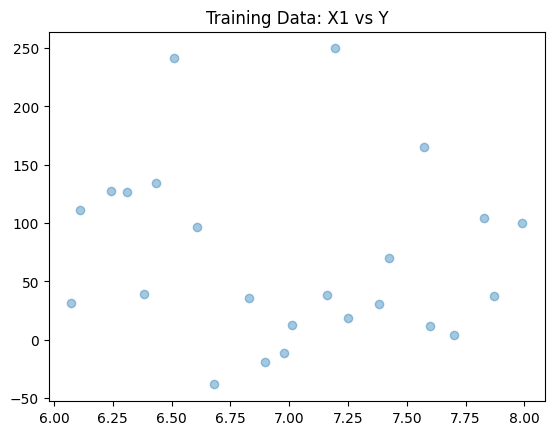

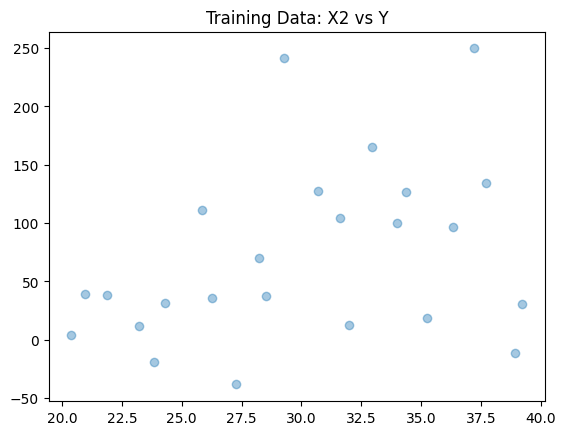

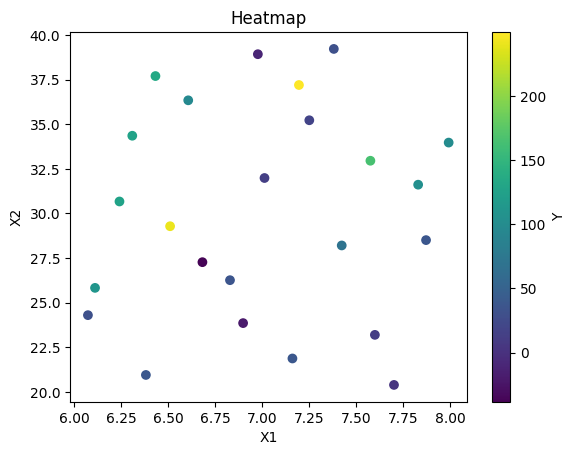

In [5]:
# Simple plot to see what training data looks like
# Run this after multiple BO LOOPS to see all training data.


plt.scatter(train_X[:, 0], train_Y, alpha=0.4)
plt.title("Training Data: X1 vs Y")
plt.show()

plt.scatter(train_X[:, 1], train_Y, alpha=0.4)
plt.title("Training Data: X2 vs Y")
plt.show()

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, alpha=0.99)
plt.title("Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label='Y')
plt.show()


In [6]:
# Gaussian Process Model

# Only for further GP Model development

# Setup (Assume train_X, train_Y, bounds, and objective_function are defined)
# ===========================



# GP Model definition
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None,
                 lengthscale_constraint = None, outputscale_constraint=None):

        if fixed_noise:
            print(f"Training with FIXED noise: {noise_level} = std dev.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood()
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
            lower_noise = lower_noise_bound**2  # lower noise bound
            upper_noise = upper_noise_bound**2  # upper noise bound

            # Add a **prior** (softly nudges during training)
            
            self.likelihood.noise_covar.register_prior(
                "noise_prior",
                SmoothedBoxPrior(lower_noise, upper_noise),
                "raw_noise"
            )
            
            # Add a **constraint** (hard bounding box)
            self.likelihood.noise_covar.register_constraint(
                "raw_noise",
                Interval(lower_noise, upper_noise)
            )
            

        self.mean_module = means.ConstantMean()#ZeroMean() # this is default ConstantMean() in GPyTorch. Worth investigating

        matern_kernel = kernels.MaternKernel(
            nu=nu,
            ard_num_dims=dim,
            lengthscale_prior=lengthscale_prior,
            lengthscale_constraint=lengthscale_constraint,
        )

        self.covar_module = kernels.ScaleKernel(
            base_kernel=matern_kernel,
            outputscale_prior=outputscale_prior,
            outputscale_constraint=outputscale_constraint,
        )
        
        
        

        
# Training function
def train_GP_model(train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                   lengthscale_prior=None, outputscale_prior=None,
                   lengthscale_constraint = None, outputscale_constraint=None): 
    model = GPModel(
        train_X, train_Y,
        fixed_noise=fixed_noise,
        noise_level=noise_level,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior,
        lengthscale_constraint = lengthscale_constraint, 
        outputscale_constraint=outputscale_constraint
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    #===== Fit the model =====#
    fit_gpytorch_mll(mll) # This is the default (turn off the custom training loop below if using this)

    # to use a custom optimizer and make this model fully customizable you can use the bit below 
    # make sure to turn off the fit_gpytorch_mll above
    '''
    # Custom training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    model.train()
    mll.train()
    training_iter = 50
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y.squeeze(-1))
        loss.backward()
        optimizer.step()
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")
    #===== End of custom training loop =====#
    '''
    return model, mll


In [7]:
# tests to see that the model is working with fixed or learnable noise

# Train with fixed noise (10%)
model_fixed = train_GP_model(train_X, train_Y, fixed_noise=True, noise_level=noise_level)

# Train with learned noise
model_learn = train_GP_model(train_X, train_Y, fixed_noise=False)

Training with FIXED noise: 25 = std dev.
Training with LEARNABLE noise (Gaussian Likelihood).


In [8]:
# tests to see the model prediction vs true function

model, mll = train_GP_model(train_X, train_Y, noise_level=noise_level)
with torch.no_grad():
    model.eval()
    model.likelihood.eval()
    test_x = train_X  # we use training points
    posterior = model.posterior(test_x)
    pred_mean = posterior.mean
    pred_std = posterior.variance.sqrt()

    print(f"True Y (first 5):      {train_Y[:5].squeeze().numpy()}")
    print(f"Pred Mean (first 5):   {pred_mean[:5].squeeze().numpy()}")
    print(f"Pred Std Dev (first 5):{pred_std[:5].squeeze().numpy()}")


Training with LEARNABLE noise (Gaussian Likelihood).
True Y (first 5):      [  4.20863913  37.46942217 111.32450568 127.62752351  12.88534731]
Pred Mean (first 5):   [  7.80474294  39.29173449 109.20812892 124.64172072  16.01872385]
Pred Std Dev (first 5):[16.72994338 16.72994338 16.72994338 16.72994338 16.72994338]


In [9]:
# Functions for plotting acquisition and GP surface

def plot_acquisition(acq_func, bounds, title="Acquisition Function"):
    """
    Plots a 2D acquisition function in raw input space.
    
    Parameters:
    - acq_func: acquisition function (expects unnormalized input)
    - bounds: tensor of shape [2, d] with raw input bounds
    - title: optional title for the plot
    """
    # Create a grid in raw space
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], 100)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], 100)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    
    with torch.no_grad():
        # Evaluate acquisition function (expects [n, 1, d])
        acq_values = acq_func(X_raw.unsqueeze(1)).squeeze(-1).cpu()

    # Reshape for heatmap
    Z = acq_values.reshape(100, 100)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap="viridis")
    plt.colorbar(label="Acquisition Value")
    plt.scatter(train_X[:, 0].cpu(), train_X[:, 1].cpu(), c="white", edgecolor="black", s=30, label="Train Points")
    plt.scatter(candidate[:, 0].cpu(), candidate[:, 1].cpu(), c="red", marker="*", s=100, label="Next Candidate")
    plt.legend()
    plt.xlabel("X1 (raw)")
    plt.ylabel("X2 (raw)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_gp_surface(model, bounds, grid_size=50, plot_type="mean", title=None):
    """
    Plots the posterior mean or standard deviation (uncertainty) of a 2D GP model.
    
    Parameters:
    - model: trained GP model (expects raw input if input_transform is set)
    - bounds: tensor of shape [2, d] with raw input bounds
    - grid_size: number of grid points per dimension
    - plot_type: "mean" or "std"
    - title: optional title for the plot
    """
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    with torch.no_grad():
        posterior = model.posterior(X_raw)
        if plot_type == "mean":
            Z = posterior.mean.reshape(grid_size, grid_size).cpu()
        elif plot_type == "std":
            Z = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()
        else:
            raise ValueError("plot_type must be 'mean' or 'std'")

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap=cm.viridis)
    ax.set_xlabel("X1 (raw)")
    ax.set_ylabel("X2 (raw)")
    ax.set_zlabel(plot_type)
    ax.set_title(title or f"GP Posterior {plot_type.capitalize()} Surface")
    plt.tight_layout()
    plt.show()



=== Iteration 1 ===
Training with LEARNABLE noise (Gaussian Likelihood).


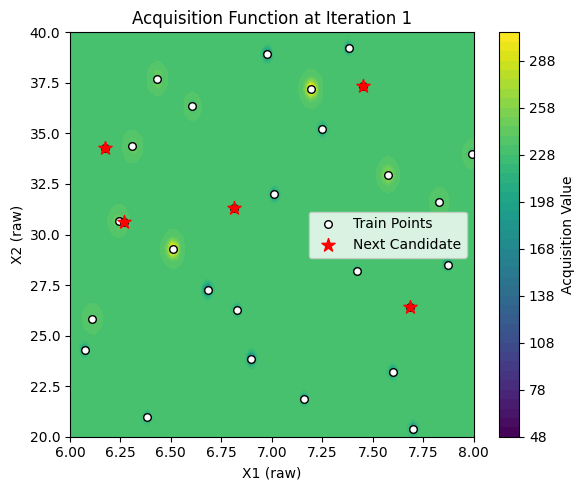

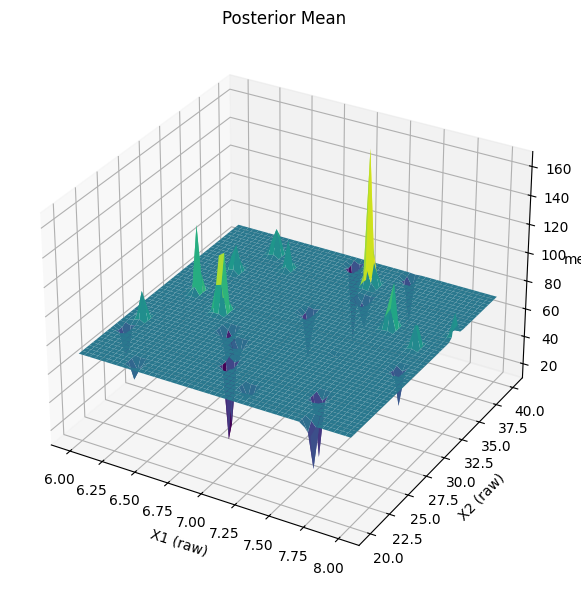

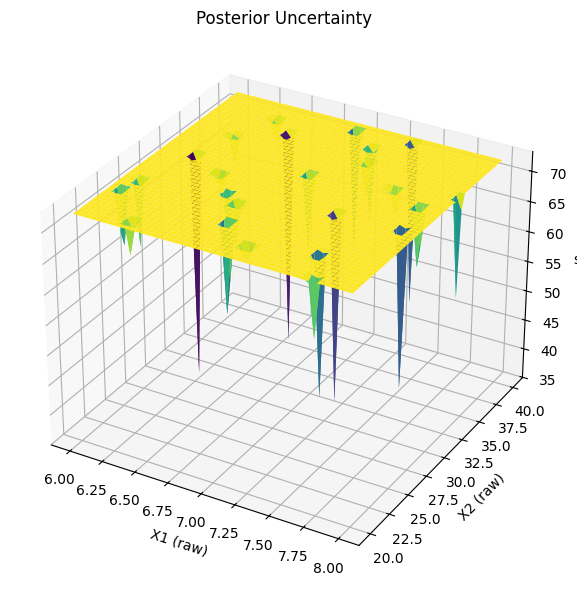

Best Y: 249.7091 at X: tensor([ 7.1955, 37.2009], dtype=torch.float64)
=== Hyperparameters after training ===
Outputscale: 0.907227
Lengthscale : tensor([[0.0069, 0.0116]], grad_fn=<SoftplusBackward0>)
Expected noise variance: 625
Noise (constrained): 0.0511078235453082
Noise raw param: 0.05540521189824676

=== Iteration 2 ===
Training with LEARNABLE noise (Gaussian Likelihood).


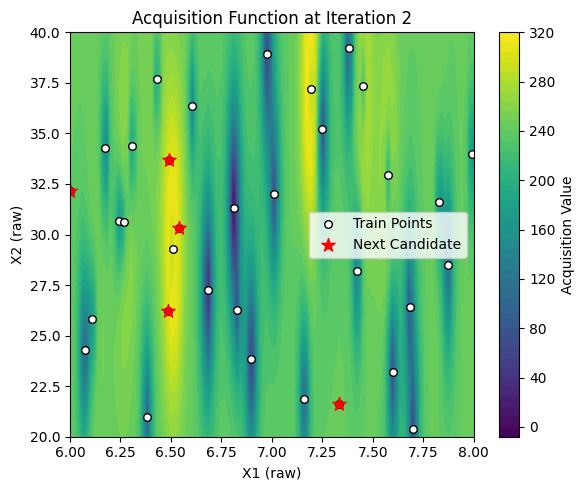

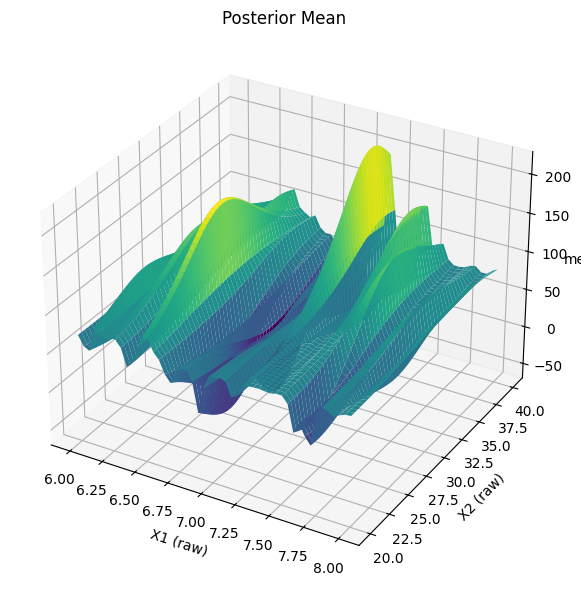

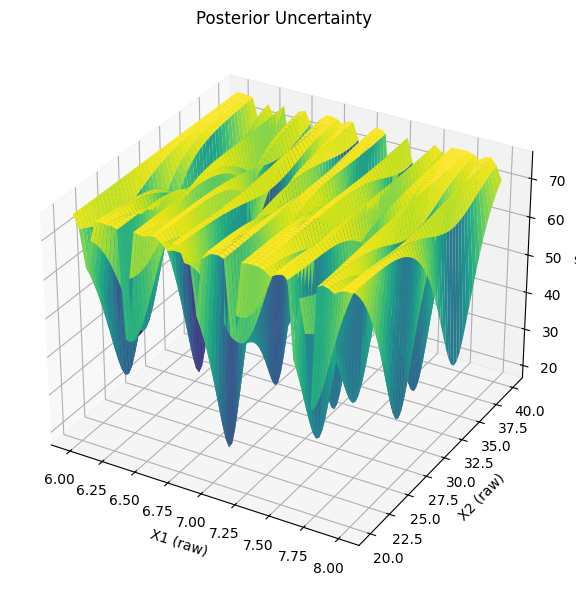

Best Y: 260.0220 at X: tensor([ 6.4922, 33.6631], dtype=torch.float64)
=== Hyperparameters after training ===
Outputscale: 0.912373
Lengthscale : tensor([[0.0149, 0.2566]], grad_fn=<SoftplusBackward0>)
Expected noise variance: 625
Noise (constrained): 0.05020140414767002
Noise raw param: 0.010070161384415832

=== Iteration 3 ===
Training with LEARNABLE noise (Gaussian Likelihood).


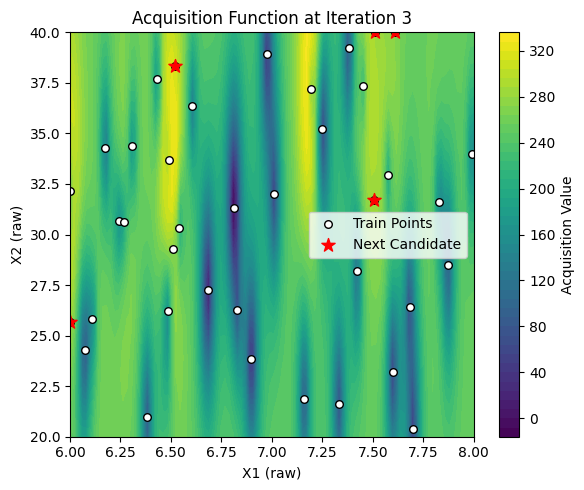

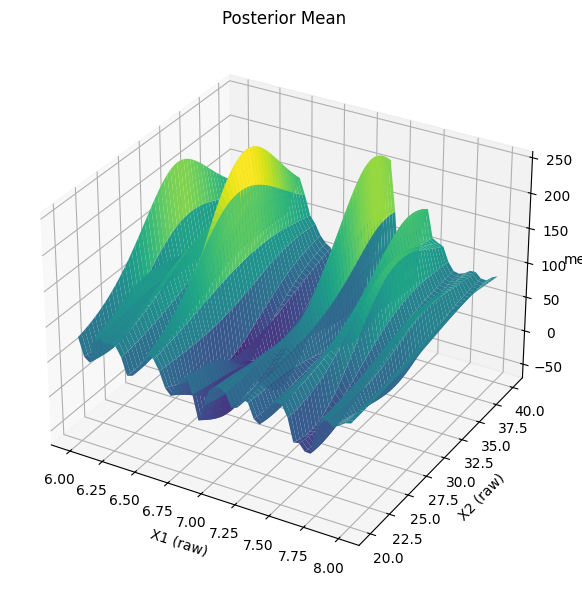

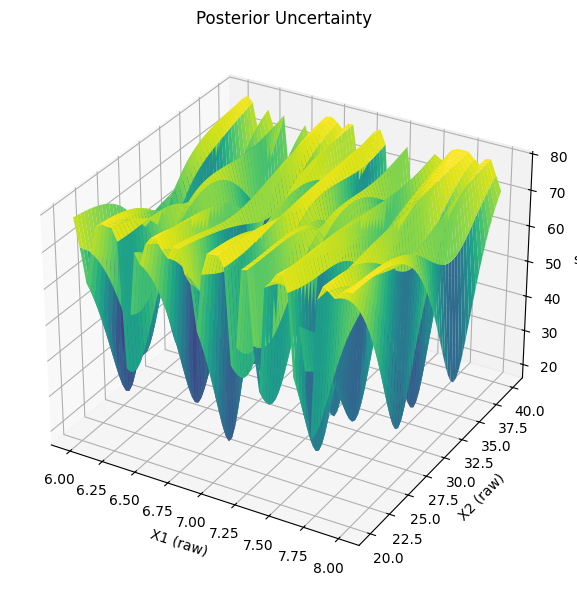

Best Y: 260.0220 at X: tensor([ 6.4922, 33.6631], dtype=torch.float64)
=== Hyperparameters after training ===
Outputscale: 0.855168
Lengthscale : tensor([[0.0201, 0.2964]], grad_fn=<SoftplusBackward0>)
Expected noise variance: 625
Noise (constrained): 0.050199936031428735
Noise raw param: 0.009996753730078096

=== Iteration 4 ===
Training with LEARNABLE noise (Gaussian Likelihood).


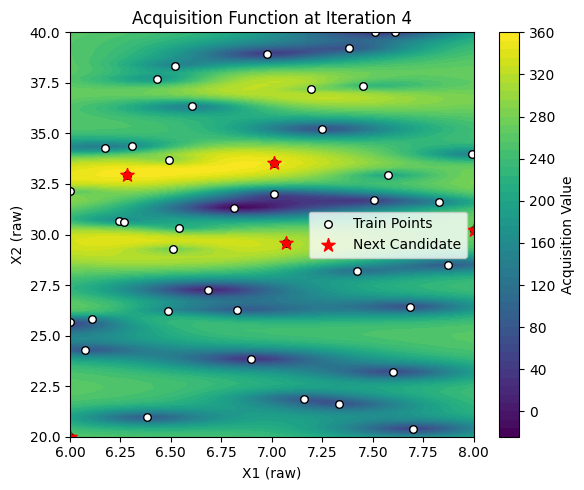

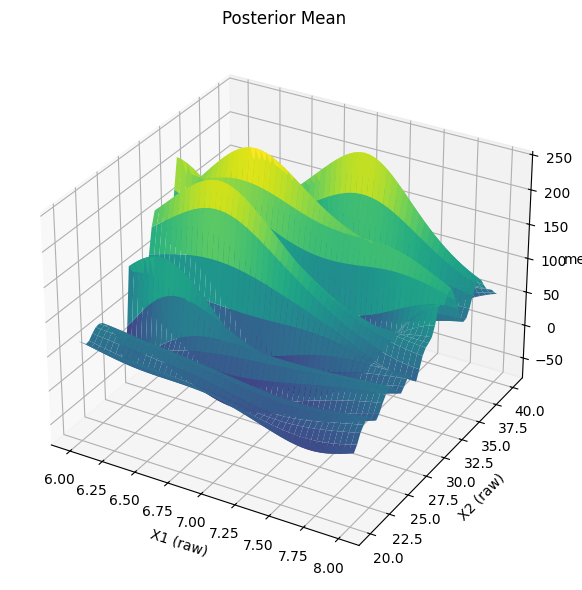

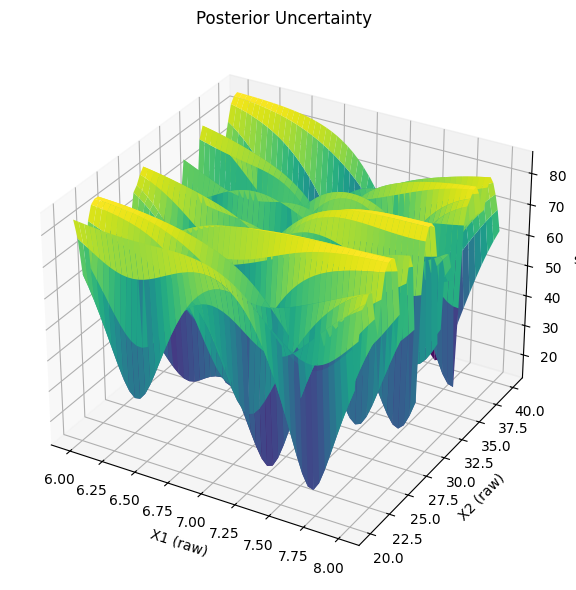

Best Y: 332.3961 at X: tensor([ 7.0112, 33.5497], dtype=torch.float64)
=== Hyperparameters after training ===
Outputscale: 1.026569
Lengthscale : tensor([[0.2637, 0.0319]], grad_fn=<SoftplusBackward0>)
Expected noise variance: 625
Noise (constrained): 0.05179900115851435
Noise raw param: 0.09001064353328869

=== Iteration 5 ===
Training with LEARNABLE noise (Gaussian Likelihood).


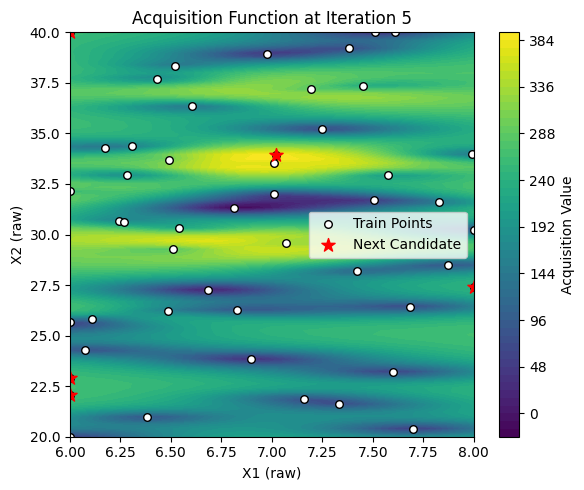

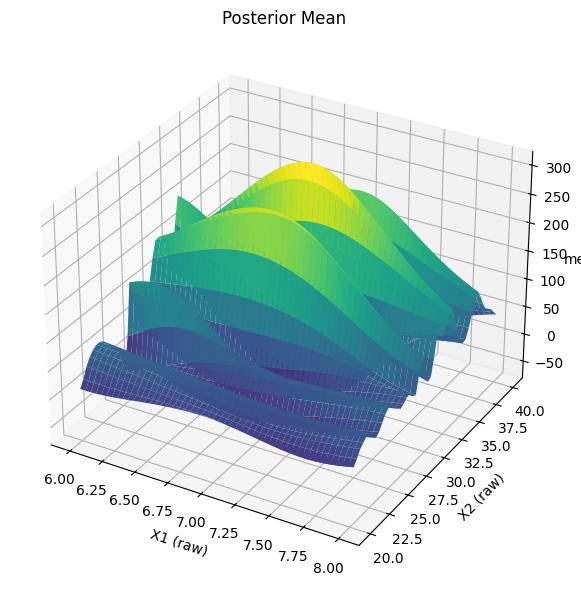

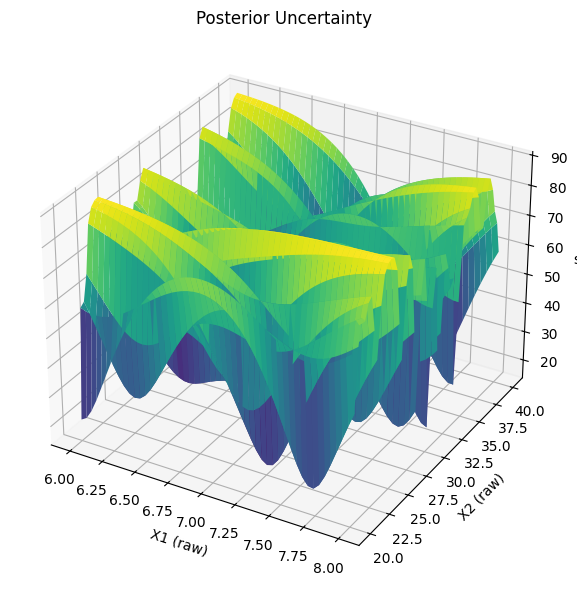

Best Y: 336.7824 at X: tensor([ 7.0201, 33.9170], dtype=torch.float64)
=== Hyperparameters after training ===
Outputscale: 0.898359
Lengthscale : tensor([[0.3267, 0.0293]], grad_fn=<SoftplusBackward0>)
Expected noise variance: 625
Noise (constrained): 0.05179883801656984
Noise raw param: 0.09000246990495707
Max predicted mean: 320.2042465996848


In [10]:
# BO Loop
# ===========================
# The learning stacks, so you can repeat this loop to get better results.


normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations = iterations # of BO LOOP 

num_restarts = 5 # restarts loop if it can't converge answer (also can improve answer by finding a better local optima)
raw_samples = 20 # total resamples taken for analysis
batch_size = batch_size # this is q THE REALWORLD # of EXPENSIVE EXPERIMENTS that your willing to do per BATCH

for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    # Train model
    model, mll = train_GP_model(train_X, train_Y, 
                                #lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior, 
                                #lengthscale_constraint=lengthscale_constraint, outputscale_constraint=outputscale_constraint, 
                                fixed_noise=False)
    '''
    # Recompute batch_initial_conditions each iteration (important!)
    topk = torch.topk(train_Y.squeeze(), k=num_restarts, largest=True)
    batch_initial_conditions = X_normalized[topk.indices].unsqueeze(1)
    #best_f = model.outcome_transform(train_Y)[0].max().item() # best observed value so far (for EI)
    '''

    model.eval() #apparently this is good practice... though the model seemed to work fine without this
    # Acquisition function (try switching between UCB and qLogNEI to compare)
    
    
    #acq_func = qLogNoisyExpectedImprovement(model=model, X_baseline=train_X)
    
    acq_func = qUpperConfidenceBound(model=model, beta=beta) # this is the UCB acquisition function

    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    # Evaluate objective
    new_y = objective_function(candidate)
    train_X = torch.cat([train_X, candidate], dim=0)
    train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)], dim=0)

    # Posterior info
    '''
    for i in range(batch_size):
        posterior = model.posterior(candidate_raw[i].unsqueeze(0))
        print(f"  Candidate {i+1}:")
        print(f"  Input: {candidate_raw[i].numpy()}")
        print(f"  Predicted mean: {posterior.mean.item():.4f}")
        print(f"  Predicted std:  {posterior.variance.sqrt().item():.4f}")
        print(f"  New y:          {new_y[i].item():.4f}")
    '''
    # Optional: Plot acquisition function
    plot_acquisition(acq_func, bounds, title=f"Acquisition Function at Iteration {iteration+1}")
    plot_gp_surface(model, bounds, plot_type="mean", title="Posterior Mean")
    plot_gp_surface(model, bounds, plot_type="std", title="Posterior Uncertainty")

    plt.show()
    best_idx = torch.argmax(train_Y.squeeze(-1))
    best_X = train_X[best_idx]
    best_Y = train_Y[best_idx].item()
    
    print(f"Best Y: {best_Y:.4f} at X: {best_X}")
    print("=== Hyperparameters after training ===")
    print(f"Outputscale: {model.covar_module.outputscale.item():.6f}")
    
    
    print(f"Lengthscale : {model.covar_module.base_kernel.lengthscale}")
    

    print("Expected noise variance:", noise_level**2)
    if hasattr(model.likelihood, "noise_covar"):
        print(f"Noise (constrained): {model.likelihood.noise_covar.noise.item()}")
        print(f"Noise raw param: {model.likelihood.noise_covar.raw_noise.item()}")

print("Max predicted mean:", model.posterior(train_X).mean.max().item())

In [11]:
# check to see how much datas you've collected
print (train_X.shape)
print (train_Y.shape)

torch.Size([49, 2])
torch.Size([49, 1])


In [12]:
# Summarize gp model function

def summarize_gp_model(model, X_train, X_test=None, save_csv=False, csv_path="gp_diagnostics.csv"):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(X_train)
        mean = posterior.mean
        stddev = posterior.variance.sqrt()

    # Extract parameters
    lengthscale = model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
    outputscale = model.covar_module.outputscale.detach().cpu().numpy()
    noise = model.likelihood.noise.detach().cpu().numpy()

    # Print diagnostics
    print("=== GP Model Diagnostics ===")
    print("ARD Lengthscales:", lengthscale)
    print("Outputscale:", outputscale)
    '''
    print("Noise:", noise)
    print("Predictive Mean (first 5):", mean[:5].squeeze().cpu().numpy())
    print("Predictive StdDev (first 5):", stddev[:5].squeeze().cpu().numpy())
    '''

    # === 2D Visualization ===
    if X_train.shape[1] == 2:
        x = X_train[:, 0].cpu().numpy()
        y = X_train[:, 1].cpu().numpy()
        z = mean.squeeze().cpu().numpy()
        err = stddev.squeeze().cpu().numpy()

        #tests
        #print(x)
        #print(y)
        #print(z)
        
        # Predictive mean scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=z, cmap='viridis', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Mean")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Mean at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Predictive stddev scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=err, cmap='plasma', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Stddev")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Uncertainty at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Optional: grid-based contour ===
        if X_test is not None:
            model.eval()
            with torch.no_grad():
                test_posterior = model.posterior(X_test)
                test_mean = test_posterior.mean.cpu().numpy()
                test_stddev = test_posterior.variance.sqrt().cpu().numpy()

            xg = X_test[:, 0].cpu().numpy()
            yg = X_test[:, 1].cpu().numpy()
            zg = test_mean.squeeze()
            errg = test_stddev.squeeze()

            # Interpolate for contour plot
            xi = np.linspace(xg.min(), xg.max(), 100)
            yi = np.linspace(yg.min(), yg.max(), 100)
            Xi, Yi = np.meshgrid(xi, yi)
            Zi = griddata((xg, yg), zg, (Xi, Yi), method='cubic')
            Ei = griddata((xg, yg), errg, (Xi, Yi), method='cubic')

            # Contour plot for predictive mean
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Zi, cmap='viridis')
            plt.colorbar(cs, label="Predictive Mean")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Mean (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Contour plot for stddev
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Ei, cmap='plasma')
            plt.colorbar(cs, label="Predictive Stddev")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Uncertainty (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("2D visualization skipped: input is not 2D.")

    # Bar plot of inverse lengthscales
    inv_lengthscale = 1.0 / lengthscale
    norm_inv_lengthscale = inv_lengthscale / inv_lengthscale.sum()

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(norm_inv_lengthscale[0])), norm_inv_lengthscale[0])
    plt.title("Normalized Inverse Lengthscales (Feature Importance)")
    plt.xlabel("Input Dimension")
    plt.ylabel("Relative Importance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    if save_csv:
        df = pd.DataFrame({
            "lengthscale": lengthscale[0],
            "inv_lengthscale": inv_lengthscale[0],
            "norm_inv_lengthscale": norm_inv_lengthscale[0],
            "outputscale": [outputscale] * len(lengthscale[0]),
            "noise": [noise] * len(lengthscale[0]),
        })
        df.to_csv(csv_path, index=False)
        print(f"Diagnostics saved to {csv_path}")



=== GP Model Diagnostics ===
ARD Lengthscales: [[0.3266639  0.02928549]]
Outputscale: 0.8983591


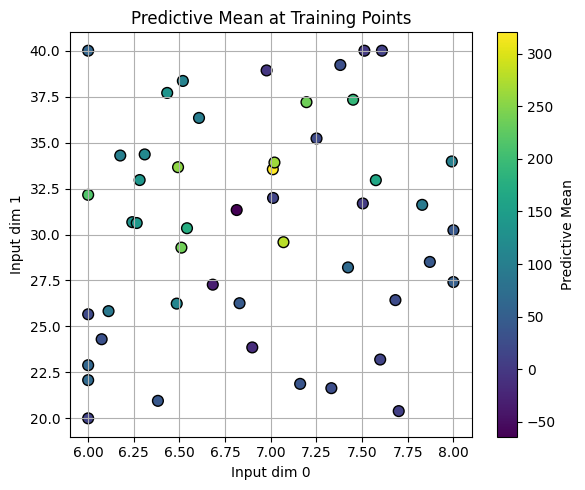

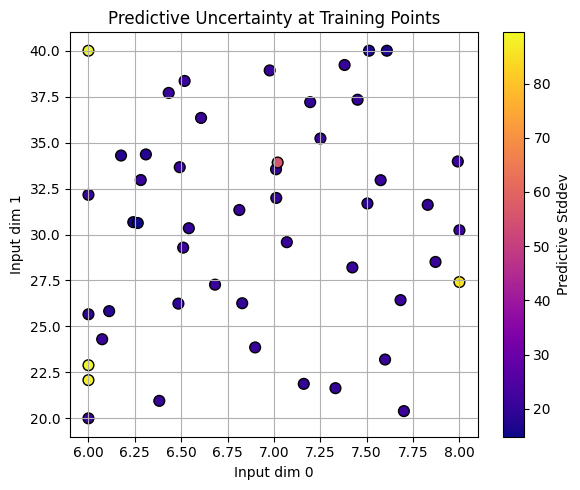

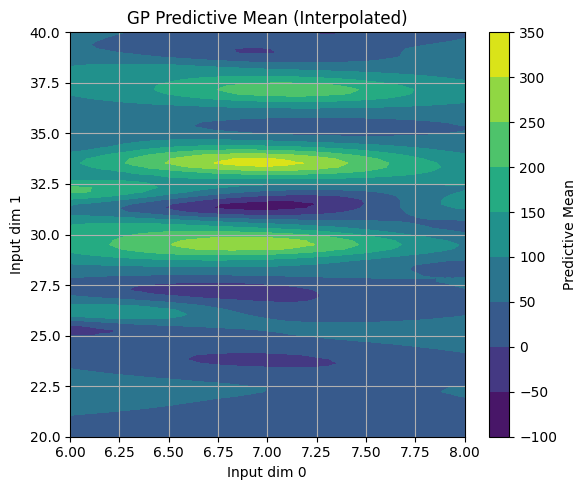

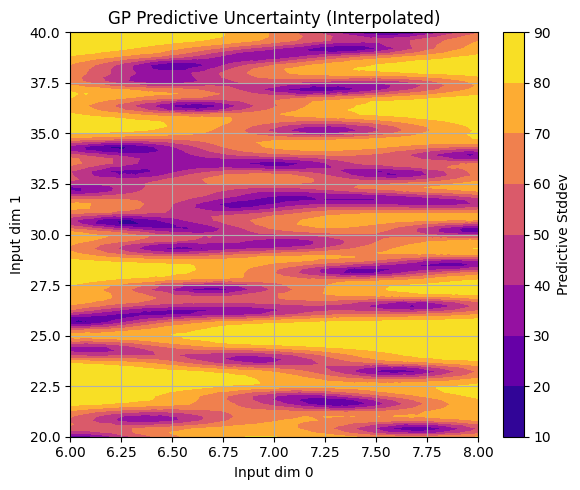

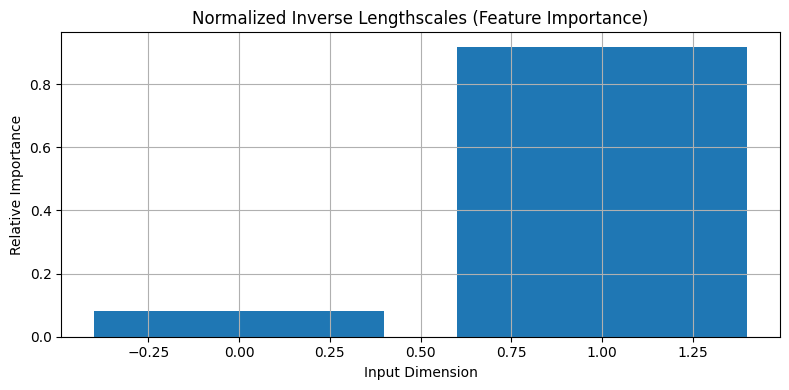

In [13]:
x1 = torch.linspace(6.0, 8.0, 50)
x2 = torch.linspace(20.0, 40.0, 50)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
X_test = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

summarize_gp_model(model, train_X, X_test=X_test)


In [14]:
def plot_bo_diagnostics(model, acq_func, train_X, bounds, latest_candidate, title_prefix="BO Diagnostics", grid_size=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    with torch.no_grad():
        posterior = model.posterior(X_raw)
        mean = posterior.mean.reshape(grid_size, grid_size).cpu()
        std = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()

        acq_vals = acq_func(X_raw.unsqueeze(1)).squeeze(-1).reshape(grid_size, grid_size).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for ax, Z, cmap, title in zip(
        axs,
        [mean, std, acq_vals],
        ["viridis", "magma", "plasma"],
        ["Posterior Mean", "Posterior Std", "Acquisition Function"]
    ):
        im = ax.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap=cmap)
        ax.scatter(train_X[:, 0], train_X[:, 1], c='red', s=30, edgecolor='white', label='Train Points')
        ax.scatter(latest_candidate[:, 0], latest_candidate[:, 1], c='red', s=100, marker='*', label='Latest Candidate')
        ax.set_title(f"{title_prefix} - {title}")
        ax.set_xlabel("X1 (raw)")
        ax.set_ylabel("X2 (raw)")
        ax.legend()

    fig.colorbar(im, ax=axs[2], label="Acquisition Value")
    plt.tight_layout()
    plt.show()


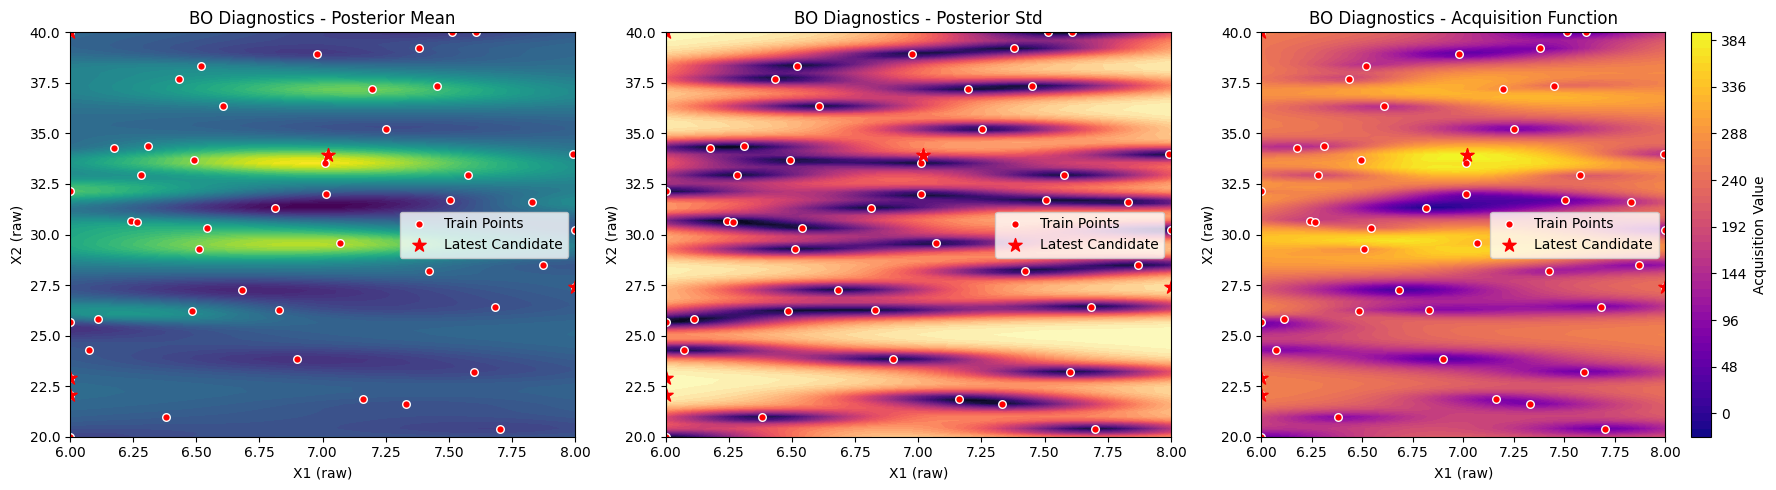

In [15]:
plot_bo_diagnostics(model, acq_func, train_X, bounds, candidate)

In [16]:
def mse_loss(predictions, targets):
    predictions = predictions.squeeze(-1)
    targets = targets.squeeze(-1)
    return torch.mean((predictions - targets) ** 2)

def r_squared(predictions, targets):
    predictions = predictions.squeeze(-1)
    targets = targets.squeeze(-1)
    ss_total = torch.sum((targets - torch.mean(targets)) ** 2)
    ss_residual = torch.sum((targets - predictions) ** 2)
    return 1 - ss_residual / ss_total

def mape_loss(predictions, targets):
    predictions = predictions.squeeze(-1)
    targets = targets.squeeze(-1)
    return torch.mean(torch.abs((targets - predictions) / (targets + 1e-8))) * 100

model.eval()
with torch.no_grad():
    posterior_test = model.posterior(train_X)
    mean_test = posterior_test.mean
    stddev = posterior_test.variance.sqrt()

# Calculate metrics against noisy training data
mse_noisy = mse_loss(mean_test, train_Y)
r2_noisy = r_squared(mean_test, train_Y)
mape_noisy = mape_loss(mean_test, train_Y)

# Calculate metrics against true (noise-free) function values
true_Y = objective_function(train_X, noise_level=0.0).unsqueeze(-1)
mse_true = mse_loss(mean_test, true_Y)
r2_true = r_squared(mean_test, true_Y)
mape_true = mape_loss(mean_test, true_Y)

print(f"Learned Noise: {model.likelihood.noise_covar.noise.max().item():.6f}")

print(f"\nMetrics vs Noisy Observations:")
print(f"  MSE:  {mse_noisy.item():.4f}")
print(f"  R²:   {r2_noisy.item():.4f}")
print(f"  MAPE: {mape_noisy.item():.2f}%")

print(f"\nMetrics vs True Function (Noise-Free):")
print(f"  MSE:  {mse_true.item():.4f}")
print(f"  R²:   {r2_true.item():.4f}")
print(f"  MAPE: {mape_true.item():.2f}%")


Learned Noise: 0.051799

Metrics vs Noisy Observations:
  MSE:  264.3625
  R²:   0.9716
  MAPE: 41.76%

Metrics vs True Function (Noise-Free):
  MSE:  574.1206
  R²:   0.9288
  MAPE: 50.87%
